**Last Updated**: *24 April 2025*

**Part I: Preparing data**

In [3]:
# === Modules ===
import numpy as np
import torch
import torch.nn as nn # nn models
import torch.optim as optim # optimization algorithms (incl. stocastic gradient descend)
import torch.nn.functional as F # activation functions (incl. ReLu)
from torch.utils.data import TensorDataset, DataLoader, Subset, random_split, ConcatDataset, WeightedRandomSampler # dataset management
from torchvision.transforms import v2 # transformations (inc. random rotation)
import random
import time
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import optuna
from optuna.trial import TrialState

In [4]:
# === Functions: Spliting & Data augmentation ===

# Data spliting 
def split_dataset(base_dataset, cd_ids, val_perc=0.2, test_perc=0.2, random_seed=42):
    
    id_to_indices = {id_: [] for id_ in np.unique(cd_ids)}
    for i, id_ in enumerate(cd_ids):
        id_to_indices[id_].append(i)
    random.seed(random_seed)
    id_list = list(id_to_indices.keys())
    random.shuffle(id_list)

    n = len(id_list)
    val_n = int(val_perc * n)
    test_n = int(test_perc * n)

    val_ids = id_list[:val_n]
    test_ids = id_list[val_n:val_n + test_n]
    train_ids = id_list[val_n + test_n:]

    val_idx = [i for id_ in val_ids for i in id_to_indices[id_]]
    test_idx = [i for id_ in test_ids for i in id_to_indices[id_]]
    train_idx = [i for id_ in train_ids for i in id_to_indices[id_]]

    return Subset(base_dataset, train_idx), Subset(base_dataset, val_idx), Subset(base_dataset, test_idx)

# Data augmentation
augment_transform = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),         # horizontal flip with a prob of 50%
    v2.RandomVerticalFlip(p=0.5),           # vertival flip with a prob of 50%
    v2.RandomRotation(degrees=(90, 270))])  # random rotation between 90° and 270°  

class augment_dataset():
    def __init__(self, base_dataset, transform, n_augments=5):
        self.base_dataset = base_dataset
        self.transform = transform
        self.n_augments = n_augments

    def __len__(self):
        return len(self.base_dataset) * (1 + self.n_augments)

    def __getitem__(self, idx):
        base_idx = idx // (1 + self.n_augments)  
        augmentation_idx = idx % (1 + self.n_augments)

        x, y = self.base_dataset[base_idx]

        if augmentation_idx == 0: 
            return x, y
        else:  
            x_aug = self.transform(x)
            return x_aug, y

        
# Plot one example
def plot_dem_with_augmentations(dataset, sample_idx, n_augments=5, transform=augment_transform):
    original_img, _ = dataset[sample_idx]  
    dem_band = original_img[0]

    fig, axes = plt.subplots(1, n_augments + 1, figsize=(10, 3))

    vmin, vmax = dem_band.min().item(), dem_band.max().item()

    axes[0].imshow(dem_band.numpy(), cmap="terrain", vmin=vmin, vmax=vmax)
    axes[0].set_title("Original")
    axes[0].axis("off")

    for i in range(n_augments):
        augmented_img = transform(original_img) 
        augmented_dem = augmented_img[0]

        axes[i + 1].imshow(augmented_dem.numpy(), cmap="terrain", vmin=vmin, vmax=vmax)
        axes[i + 1].set_title(f"Aug {i + 1}")
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()

In [5]:
# === Load data ===

# Load .npy files
non_cd_data = np.load('train_non_CD_features2.npy')
non_cd_labels = np.load('train_non_CD_labels2.npy')
cd_data = np.load('train_CD_features2.npy')
cd_labels = np.load('train_CD_labels2.npy')

# Remove aspect and edge
non_cd_data = np.delete(non_cd_data, [2, 3, 6], axis=1)
cd_data = np.delete(cd_data, [2, 3, 6], axis=1)

# Print basic info
print(f"{'':<15} {'Non-CD Data':<20} {'Non-CD Labels':<20} {'CD Data':<20} {'CD Labels':<20}")
print(f"{'Shape':<15} {str(non_cd_data.shape):<20} {str(non_cd_labels.shape):<20} {str(cd_data.shape):<20} {str(cd_labels.shape):<20}")
print(f"{'Dtype':<15} {str(non_cd_data.dtype):<20} {str(non_cd_labels.dtype):<20} {str(cd_data.dtype):<20} {str(cd_labels.dtype):<20}")
print(f"{'Range/Value':<15} {str(non_cd_data.min())+' - '+str(non_cd_data.max()):<20} {str(non_cd_labels.mean()):<20} {str(cd_data.min())+' - '+str(cd_data.max()):<20} {str(cd_labels.mean()):<20}")

                Non-CD Data          Non-CD Labels        CD Data              CD Labels           
Shape           (9993, 4, 50, 50)    (9993,)              (223, 4, 50, 50)     (223,)              
Dtype           float32              int32                float32              int32               
Range/Value     0.0 - 1.0            0.0                  0.0 - 1.0            1.0                 


                CD Data                        CD Labels                     
Shape           torch.Size([223, 4, 50, 50])   torch.Size([223])             


                               Training                       Validation                     Testing                       
Percentage of CD dataset       70%                            30%                            0%                            
Number of CDs                  152                            71                             0                             
Number of augmented CDs        760                            0                              0                             


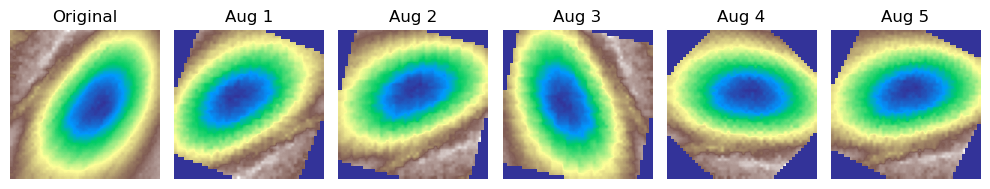

In [6]:
# === Prepare CD data ===

# Convert to torch tensors
cd_data_torch = torch.tensor(cd_data, dtype=torch.float32)
cd_labels_torch = torch.tensor(cd_labels, dtype=torch.long)
print(f"{'':<15} {'CD Data':<30} {'CD Labels':<30}")
print(f"{'Shape':<15} {str(cd_data_torch.shape):<30} {str(cd_labels_torch.shape):<30}")

base_dataset = TensorDataset(cd_data_torch, cd_labels_torch)

# Split into 60/20/20 for training/validation/testing
cd_ids = np.load("train_CD_id.npy") # split taking CD id into accound to avoid data leakage
val_perc = 0.3
test_perc = 0.0
train_dataset_cd, val_dataset_cd, test_dataset_cd = split_dataset(base_dataset, cd_ids, val_perc, test_perc)

# Perform data augmentation
augmented_train_dataset_cd = augment_dataset(train_dataset_cd, transform = augment_transform, n_augments=5)

# Print info 
print('\n')
print(f"{'':<30} {'Training':<30} {'Validation':<30} {'Testing':<30}")
print(f"{'Percentage of CD dataset':<30} {str(int((1-val_perc-test_perc)*100))+'%':<30} {str(int(val_perc*100))+'%':<30} {str(int(test_perc*100))+'%':<30}")
print(f"{'Number of CDs':<30} {str(len(train_dataset_cd)):<30} {str(len(val_dataset_cd)):<30} {str(len(test_dataset_cd)):<30}")
print(f"{'Number of augmented CDs':<30} {str(len(augmented_train_dataset_cd)-len(train_dataset_cd)):<30} {str('0'):<30} {str('0'):<30}")
plot_dem_with_augmentations(train_dataset_cd, sample_idx=12, n_augments=5)

In [7]:
# === Prepare Non-CD data ===

# Convert to torch tensors
non_cd_data_torch = torch.tensor(non_cd_data, dtype=torch.float32)
non_cd_labels_torch = torch.tensor(non_cd_labels, dtype=torch.long)
print(f"{'':<15} {'Non-CD Data':<30} {'Non-CD Labels':<30}")
print(f"{'Shape':<15} {str(non_cd_data_torch.shape):<30} {str(non_cd_labels_torch.shape):<30}")

negative_dataset = TensorDataset(non_cd_data_torch, non_cd_labels_torch)

# Split into 97/3/3 for training/validation/testing
val_perc_neg = 0.06
test_perc_neg = 0.0
total_neg = len(negative_dataset)
val_size_neg = int(val_perc_neg * total_neg)
test_size_neg = int(test_perc_neg * total_neg)
train_size_neg = total_neg - val_size_neg - test_size_neg

train_dataset_non_cd, val_dataset_non_cd, test_dataset_non_cd = random_split(negative_dataset, 
                                                                    [train_size_neg, val_size_neg, test_size_neg], 
                                                                    generator=torch.Generator().manual_seed(42))

# Print info
print('\n')
print(f"{'':<30} {'Training':<30} {'Validation':<30} {'Testing':<30}")
print(f"{'Percentage of non-CD dataset':<30} {str(int((1-val_perc_neg-test_perc_neg)*100))+'%':<30} {str(int(val_perc_neg*100))+'%':<30} {str(int(test_perc_neg*100))+'%':<30}")
print(f"{'Number of non-CDs':<30} {str(len(train_dataset_non_cd)):<30} {str(len(val_dataset_non_cd)):<30} {str(len(test_dataset_non_cd)):<30}")

                Non-CD Data                    Non-CD Labels                 
Shape           torch.Size([9993, 4, 50, 50])  torch.Size([9993])            


                               Training                       Validation                     Testing                       
Percentage of non-CD dataset   94%                            6%                             0%                            
Number of non-CDs              9394                           599                            0                             


In [8]:
# === Functions: Data loaders ===
def get_data_loaders(final_train_dataset, final_val_dataset, final_test_dataset):
    batch_size = 32
    
    # Compute class weights for sampler
    y_train = []
    for data in final_train_dataset:
        _, y = data
        y_train.append(y)
    y_train = torch.tensor(y_train)

    # Calculate class counts and weights
    class_counts = torch.bincount(y_train)
    class_weights = 1. / class_counts.float()
    sample_weights = class_weights[y_train]
    
    # Weighted random sampler for imbalanced data
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

    # Create DataLoaders with samplers
    train_loader = DataLoader(final_train_dataset, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(final_val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(final_test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [9]:
# === Combine CD & Non-CD data ===

# Create DataLoaders
final_train_dataset = ConcatDataset([augmented_train_dataset_cd, train_dataset_non_cd])
final_val_dataset = ConcatDataset([val_dataset_cd, val_dataset_non_cd])
final_test_dataset = ConcatDataset([test_dataset_cd, test_dataset_non_cd])

print(f"{'':<30} {'Training':<30} {'Validation':<30} {'Testing':<30}")
print(f"{'Number of samples':<30} {str(len(final_train_dataset)):<30} {str(len(final_val_dataset)):<30} {str(len(final_test_dataset)):<30}")

                               Training                       Validation                     Testing                       
Number of samples              10306                          670                            0                             


**Part II: Training and validating 2D CNN**

In [10]:
# === Set device and parameters ===
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device will run on {device}")

Device will run on cuda


In [11]:
# === Functions: CNN ===
class CNN(nn.Module):
    def __init__(self, trial, in_channels=4, num_classes=1):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        # Batch normalization layers
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
       
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Global average pooling layer
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc1 = nn.Linear(256*1*1, 128)
        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, num_classes)

        # Dropout layers
        self.dropout = nn.Dropout(trial.suggest_float("dropout", 0.4, 0.5)) # > 0.4 for robustness

    def forward(self, x):
        # Convolutional layers with ReLU activation & batch normalization 
        # & Max pooling layers
        x = F.relu(self.bn1(self.conv1(x)))         # (batch, 32, 50, 50)
        x = F.relu(self.bn2(self.conv2(x)))         # (batch, 64, 50, 50)
        x = self.pool(x)                            # (batch, 64, 25, 25)
        
        x = F.relu(self.bn3(self.conv3(x)))         # (batch, 128, 25, 25)
        x = F.relu(self.bn4(self.conv4(x)))         # (batch, 256, 25, 25)
        x = self.pool(x)                            # (batch, 256, 12, 12)

        # Average pooling layer
        x = self.global_pool(x)                     # (batch, 256, 1, 1)
        
        # Flatten
        x = torch.flatten(x, 1)                     # (batch, 256)

        # Fully connected layers with ReLU activation 
        # & Dropout layers
        x = self.dropout(F.relu(self.fc1(x)))      # (batch, 128)
        x = self.dropout(F.relu(self.fc2(x)))      # (batch, 64)
        x = self.output(x)                         # (batch, 1)

        return x

In [10]:
# === Obective function === 
def objective(trial):
    # Get the CNN model
    model = CNN(trial).to(device)

    # Hyperparameter suggestions
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    threshold = trial.suggest_float("threshold", 0.3, 0.6)
    n_epochs = 50
    
    # Load data
    train_loader, val_loader, _ = get_data_loaders(final_train_dataset, final_val_dataset, final_test_dataset)

    # Compute class weights
    train_labels = torch.cat([target for _, target in train_loader], dim=0)
    pos_count = (train_labels == 1).sum().item()
    neg_count = (train_labels == 0).sum().item()
    pos_weight = torch.tensor([neg_count / pos_count]).to(device)

    # Weighted binary classification loss
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    best_f1 = 0
    best_f1_epoch = -1
    best_model_state = None
    f1_scores, precisions, recalls, pr_aucs = [], [], [], []
    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []
    train_correct, val_correct = [], []

    for epoch in range(n_epochs):
        # Training
        train_loss = 0.0    # loss per epoch
        train_corr = 0      # number of correct predictions per epoch
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device).float()
            output = model(data).squeeze(1)
            loss = criterion(output, target)
            
            probs = torch.sigmoid(output)
            preds = (probs >= threshold).long()
            
            train_corr += (preds == target.long()).sum().item()    # add up numbers of correct predictions
            train_loss += loss.item()                              # add loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_losses.append(train_loss / len(train_loader))
        train_correct.append(train_corr)

        # Validation
        model.eval()
        val_loss = 0.0  # loss per epoch
        val_corr = 0    # number of correct predictions per epoch
        all_preds, all_targets, all_probs = [], [], []

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device).float()
                output = model(data).squeeze(1)
                loss = criterion(output, target)

                probs = torch.sigmoid(output)
                preds = (probs >= threshold).long()

                val_corr += (preds == target.long()).sum().item()
                val_loss += loss.item()

                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(target.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())

        val_losses.append(val_loss / len(val_loader))
        val_correct.append(val_corr)

        # Compute F1 score
        f1 = f1_score(all_targets, all_preds, zero_division=0)
        
        # Compute other metrics
        precision = precision_score(all_targets, all_preds, zero_division=0)
        recall = recall_score(all_targets, all_preds, zero_division=0)
        precision_curve, recall_curve, _ = precision_recall_curve(all_targets, all_probs)
        pr_auc = auc(recall_curve, precision_curve)

        # Store metrics
        f1_scores.append(f1)
        precisions.append(precision)
        recalls.append(recall)
        pr_aucs.append(pr_auc)
        train_accuracies.append(train_corr / len(train_loader.dataset))
        val_accuracies.append(val_corr / len(val_loader.dataset))

        trial.set_user_attr("f1_scores", f1_scores)
        trial.set_user_attr("precisions", precisions)
        trial.set_user_attr("recalls", recalls)
        trial.set_user_attr("pr_aucs", pr_aucs)
        trial.set_user_attr("train_accuracies", train_accuracies)
        trial.set_user_attr("val_accuracies", val_accuracies)
        trial.set_user_attr("train_losses", train_losses)
        trial.set_user_attr("val_losses", val_losses)


        # Print metrics per epoch
        print(
           f"Trial {trial.number} | Epoch {epoch+1}/{n_epochs} | "
           f"F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | "
           f"PR AUC: {pr_auc:.4f} | Train Acc: {train_accuracies[-1]:.4f} | Val Acc: {val_accuracies[-1]:.4f}")

        # Report to Optuna
        trial.report(f1, epoch)

        # Save model if it's the best so far
        if f1 > best_f1:
            best_f1 = f1
            best_f1_epoch = epoch + 1
            best_model_state = model.state_dict()

        # Early pruning
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # Save best model to file
    if best_model_state is not None:
        model_path = f"best_model_trial_{trial.number}.pt"
        torch.save(best_model_state, model_path)
        trial.set_user_attr("best_f1", best_f1)
        trial.set_user_attr("best_f1_epoch", best_f1_epoch)
        trial.set_user_attr("model_path", model_path)
    
    return best_f1

In [11]:
# === Optuna study ===
if __name__ == "__main__":
    start_time = time.time()
    study = optuna.create_study(direction="maximize", study_name="2d-cnn", storage="sqlite:///cd-study.db", load_if_exists=True)
    study.optimize(objective, n_trials=50)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
    
    elapsed_time = time.time() - start_time 

    best_trial = study.best_trial
    best_f1_epoch = best_trial.user_attrs.get("best_f1_epoch")

print("\nStudy summary:")
print(f"  Finished trials     : {len(study.trials)}")
print(f"  Pruned trials       : {len(pruned_trials)}")
print(f"  Completed trials    : {len(complete_trials)}")
print(f"\nBest Trial #{best_trial.number} Epoch #{best_f1_epoch}")
print(f"  Best F1 score       : {best_trial.value:.4f}")
print("  Best hyperparameters:")
for key, value in best_trial.params.items():
    print(f"    {key:<15}: {value}")
print(f"Time taken: {elapsed_time:.2f} seconds")

[I 2025-05-01 20:41:20,055] Using an existing study with name '2d-cnn' instead of creating a new one.


Trial 1 | Epoch 1/50 | F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | PR AUC: 0.2351 | Train Acc: 0.8850 | Val Acc: 0.8940
Trial 1 | Epoch 2/50 | F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | PR AUC: 0.2271 | Train Acc: 0.9059 | Val Acc: 0.8940
Trial 1 | Epoch 3/50 | F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | PR AUC: 0.2392 | Train Acc: 0.9027 | Val Acc: 0.8940
Trial 1 | Epoch 4/50 | F1: 0.1304 | Precision: 0.2857 | Recall: 0.0845 | PR AUC: 0.2516 | Train Acc: 0.8763 | Val Acc: 0.8806
Trial 1 | Epoch 5/50 | F1: 0.1304 | Precision: 0.2857 | Recall: 0.0845 | PR AUC: 0.2303 | Train Acc: 0.9053 | Val Acc: 0.8806
Trial 1 | Epoch 6/50 | F1: 0.0526 | Precision: 0.4000 | Recall: 0.0282 | PR AUC: 0.2762 | Train Acc: 0.9040 | Val Acc: 0.8925
Trial 1 | Epoch 7/50 | F1: 0.0779 | Precision: 0.5000 | Recall: 0.0423 | PR AUC: 0.2411 | Train Acc: 0.9140 | Val Acc: 0.8940
Trial 1 | Epoch 8/50 | F1: 0.0759 | Precision: 0.3750 | Recall: 0.0423 | PR AUC: 0.2233 | Train Acc: 0.9075 | Val Acc:

[I 2025-05-01 21:27:44,265] Trial 1 finished with value: 0.35185185185185186 and parameters: {'dropout': 0.4951613819847368, 'lr': 0.0036495697286070255, 'threshold': 0.5136369303677939}. Best is trial 1 with value: 0.35185185185185186.


Trial 1 | Epoch 50/50 | F1: 0.2889 | Precision: 0.6842 | Recall: 0.1831 | PR AUC: 0.4346 | Train Acc: 0.9335 | Val Acc: 0.9045
Trial 2 | Epoch 1/50 | F1: 0.1774 | Precision: 0.2075 | Recall: 0.1549 | PR AUC: 0.2183 | Train Acc: 0.8607 | Val Acc: 0.8478
Trial 2 | Epoch 2/50 | F1: 0.2115 | Precision: 0.3333 | Recall: 0.1549 | PR AUC: 0.2689 | Train Acc: 0.8907 | Val Acc: 0.8776
Trial 2 | Epoch 3/50 | F1: 0.2609 | Precision: 0.3409 | Recall: 0.2113 | PR AUC: 0.2711 | Train Acc: 0.9006 | Val Acc: 0.8731
Trial 2 | Epoch 4/50 | F1: 0.2017 | Precision: 0.2500 | Recall: 0.1690 | PR AUC: 0.2376 | Train Acc: 0.9079 | Val Acc: 0.8582
Trial 2 | Epoch 5/50 | F1: 0.1887 | Precision: 0.2857 | Recall: 0.1408 | PR AUC: 0.2811 | Train Acc: 0.9089 | Val Acc: 0.8716
Trial 2 | Epoch 6/50 | F1: 0.3673 | Precision: 0.2586 | Recall: 0.6338 | PR AUC: 0.2314 | Train Acc: 0.9124 | Val Acc: 0.7687
Trial 2 | Epoch 7/50 | F1: 0.1609 | Precision: 0.4375 | Recall: 0.0986 | PR AUC: 0.2786 | Train Acc: 0.9108 | Val Acc

[I 2025-05-01 22:17:26,102] Trial 2 finished with value: 0.39263803680981596 and parameters: {'dropout': 0.462674922325811, 'lr': 0.0008809297505756374, 'threshold': 0.35456858361476984}. Best is trial 2 with value: 0.39263803680981596.


Trial 2 | Epoch 50/50 | F1: 0.2381 | Precision: 0.7692 | Recall: 0.1408 | PR AUC: 0.3798 | Train Acc: 0.9786 | Val Acc: 0.9045
Trial 3 | Epoch 1/50 | F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | PR AUC: 0.2672 | Train Acc: 0.8700 | Val Acc: 0.8940
Trial 3 | Epoch 2/50 | F1: 0.0789 | Precision: 0.6000 | Recall: 0.0423 | PR AUC: 0.3116 | Train Acc: 0.9044 | Val Acc: 0.8955
Trial 3 | Epoch 3/50 | F1: 0.1220 | Precision: 0.4545 | Recall: 0.0704 | PR AUC: 0.3579 | Train Acc: 0.9090 | Val Acc: 0.8925
Trial 3 | Epoch 4/50 | F1: 0.1266 | Precision: 0.6250 | Recall: 0.0704 | PR AUC: 0.2988 | Train Acc: 0.9127 | Val Acc: 0.8970
Trial 3 | Epoch 5/50 | F1: 0.2105 | Precision: 0.4167 | Recall: 0.1408 | PR AUC: 0.3506 | Train Acc: 0.9159 | Val Acc: 0.8881
Trial 3 | Epoch 6/50 | F1: 0.2393 | Precision: 0.3043 | Recall: 0.1972 | PR AUC: 0.3286 | Train Acc: 0.9125 | Val Acc: 0.8672
Trial 3 | Epoch 7/50 | F1: 0.0800 | Precision: 0.7500 | Recall: 0.0423 | PR AUC: 0.3728 | Train Acc: 0.9226 | Val Acc

[I 2025-05-01 23:02:18,206] Trial 3 finished with value: 0.3853211009174312 and parameters: {'dropout': 0.48996791114660393, 'lr': 0.00021260865248170396, 'threshold': 0.5402963219033277}. Best is trial 2 with value: 0.39263803680981596.


Trial 3 | Epoch 50/50 | F1: 0.2581 | Precision: 0.5455 | Recall: 0.1690 | PR AUC: 0.2819 | Train Acc: 0.9858 | Val Acc: 0.8970
Trial 4 | Epoch 1/50 | F1: 0.1856 | Precision: 0.3462 | Recall: 0.1268 | PR AUC: 0.2921 | Train Acc: 0.8785 | Val Acc: 0.8821
Trial 4 | Epoch 2/50 | F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | PR AUC: 0.2665 | Train Acc: 0.9039 | Val Acc: 0.8925
Trial 4 | Epoch 3/50 | F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | PR AUC: 0.2684 | Train Acc: 0.9069 | Val Acc: 0.8925
Trial 4 | Epoch 4/50 | F1: 0.1250 | Precision: 0.5556 | Recall: 0.0704 | PR AUC: 0.3004 | Train Acc: 0.9058 | Val Acc: 0.8955
Trial 4 | Epoch 5/50 | F1: 0.1818 | Precision: 0.4706 | Recall: 0.1127 | PR AUC: 0.3017 | Train Acc: 0.9074 | Val Acc: 0.8925
Trial 4 | Epoch 6/50 | F1: 0.1818 | Precision: 0.3214 | Recall: 0.1268 | PR AUC: 0.2849 | Train Acc: 0.9115 | Val Acc: 0.8791
Trial 4 | Epoch 7/50 | F1: 0.1800 | Precision: 0.3103 | Recall: 0.1268 | PR AUC: 0.2898 | Train Acc: 0.9167 | Val Acc

[I 2025-05-01 23:49:28,907] Trial 4 finished with value: 0.42424242424242425 and parameters: {'dropout': 0.471181662885093, 'lr': 0.0002457462938235832, 'threshold': 0.4773263696123565}. Best is trial 4 with value: 0.42424242424242425.


Trial 4 | Epoch 50/50 | F1: 0.2353 | Precision: 0.7143 | Recall: 0.1408 | PR AUC: 0.3982 | Train Acc: 0.9828 | Val Acc: 0.9030
Trial 5 | Epoch 1/50 | F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | PR AUC: 0.2049 | Train Acc: 0.8842 | Val Acc: 0.8940
Trial 5 | Epoch 2/50 | F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | PR AUC: 0.2140 | Train Acc: 0.8953 | Val Acc: 0.8940
Trial 5 | Epoch 3/50 | F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | PR AUC: 0.2006 | Train Acc: 0.8889 | Val Acc: 0.8940
Trial 5 | Epoch 4/50 | F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | PR AUC: 0.2037 | Train Acc: 0.8889 | Val Acc: 0.8940
Trial 5 | Epoch 5/50 | F1: 0.0270 | Precision: 0.3333 | Recall: 0.0141 | PR AUC: 0.2007 | Train Acc: 0.8984 | Val Acc: 0.8925
Trial 5 | Epoch 6/50 | F1: 0.1304 | Precision: 0.2857 | Recall: 0.0845 | PR AUC: 0.2191 | Train Acc: 0.8970 | Val Acc: 0.8806
Trial 5 | Epoch 7/50 | F1: 0.0779 | Precision: 0.5000 | Recall: 0.0423 | PR AUC: 0.2448 | Train Acc: 0.9066 | Val Acc

[I 2025-05-02 00:34:18,537] Trial 5 finished with value: 0.27184466019417475 and parameters: {'dropout': 0.44059444395963077, 'lr': 0.0057447821169470115, 'threshold': 0.5304780293846977}. Best is trial 4 with value: 0.42424242424242425.


Trial 5 | Epoch 50/50 | F1: 0.2718 | Precision: 0.4375 | Recall: 0.1972 | PR AUC: 0.3574 | Train Acc: 0.9260 | Val Acc: 0.8881
Trial 6 | Epoch 1/50 | F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | PR AUC: 0.2014 | Train Acc: 0.8603 | Val Acc: 0.8940
Trial 6 | Epoch 2/50 | F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | PR AUC: 0.1190 | Train Acc: 0.8738 | Val Acc: 0.8940
Trial 6 | Epoch 3/50 | F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | PR AUC: 0.1270 | Train Acc: 0.8676 | Val Acc: 0.8940


[I 2025-05-02 00:37:47,320] Trial 6 pruned. 


Trial 6 | Epoch 4/50 | F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | PR AUC: 0.5530 | Train Acc: 0.5130 | Val Acc: 0.8940
Trial 7 | Epoch 1/50 | F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | PR AUC: 0.2920 | Train Acc: 0.8833 | Val Acc: 0.8940
Trial 7 | Epoch 2/50 | F1: 0.1869 | Precision: 0.2778 | Recall: 0.1408 | PR AUC: 0.2815 | Train Acc: 0.9067 | Val Acc: 0.8701
Trial 7 | Epoch 3/50 | F1: 0.1463 | Precision: 0.5455 | Recall: 0.0845 | PR AUC: 0.2846 | Train Acc: 0.9128 | Val Acc: 0.8955
Trial 7 | Epoch 4/50 | F1: 0.1266 | Precision: 0.6250 | Recall: 0.0704 | PR AUC: 0.3392 | Train Acc: 0.9109 | Val Acc: 0.8970
Trial 7 | Epoch 5/50 | F1: 0.2418 | Precision: 0.5500 | Recall: 0.1549 | PR AUC: 0.3518 | Train Acc: 0.9187 | Val Acc: 0.8970
Trial 7 | Epoch 6/50 | F1: 0.2093 | Precision: 0.6000 | Recall: 0.1268 | PR AUC: 0.3938 | Train Acc: 0.9190 | Val Acc: 0.8985
Trial 7 | Epoch 7/50 | F1: 0.2472 | Precision: 0.6111 | Recall: 0.1549 | PR AUC: 0.3237 | Train Acc: 0.9198 | Val Acc:

[I 2025-05-02 01:23:48,400] Trial 7 finished with value: 0.416 and parameters: {'dropout': 0.4187608842815457, 'lr': 0.00023904865876493562, 'threshold': 0.5928340403365526}. Best is trial 4 with value: 0.42424242424242425.


Trial 7 | Epoch 50/50 | F1: 0.2045 | Precision: 0.5294 | Recall: 0.1268 | PR AUC: 0.3245 | Train Acc: 0.9855 | Val Acc: 0.8955
Trial 8 | Epoch 1/50 | F1: 0.3324 | Precision: 0.2086 | Recall: 0.8169 | PR AUC: 0.1902 | Train Acc: 0.8655 | Val Acc: 0.6522
Trial 8 | Epoch 2/50 | F1: 0.1856 | Precision: 0.3462 | Recall: 0.1268 | PR AUC: 0.2759 | Train Acc: 0.9066 | Val Acc: 0.8821
Trial 8 | Epoch 3/50 | F1: 0.1684 | Precision: 0.3333 | Recall: 0.1127 | PR AUC: 0.2702 | Train Acc: 0.9125 | Val Acc: 0.8821
Trial 8 | Epoch 4/50 | F1: 0.1818 | Precision: 0.4706 | Recall: 0.1127 | PR AUC: 0.2722 | Train Acc: 0.9157 | Val Acc: 0.8925
Trial 8 | Epoch 5/50 | F1: 0.2500 | Precision: 0.3939 | Recall: 0.1831 | PR AUC: 0.3054 | Train Acc: 0.9110 | Val Acc: 0.8836
Trial 8 | Epoch 6/50 | F1: 0.1698 | Precision: 0.2571 | Recall: 0.1268 | PR AUC: 0.2638 | Train Acc: 0.9104 | Val Acc: 0.8687
Trial 8 | Epoch 7/50 | F1: 0.1039 | Precision: 0.6667 | Recall: 0.0563 | PR AUC: 0.3485 | Train Acc: 0.9206 | Val Acc

[I 2025-05-02 02:09:05,263] Trial 8 finished with value: 0.4036697247706422 and parameters: {'dropout': 0.46030390674074034, 'lr': 0.0002614628899588933, 'threshold': 0.4597420876153685}. Best is trial 4 with value: 0.42424242424242425.


Trial 8 | Epoch 50/50 | F1: 0.2247 | Precision: 0.5556 | Recall: 0.1408 | PR AUC: 0.3503 | Train Acc: 0.9829 | Val Acc: 0.8970
Trial 9 | Epoch 1/50 | F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | PR AUC: 0.3317 | Train Acc: 0.8265 | Val Acc: 0.8925
Trial 9 | Epoch 2/50 | F1: 0.2626 | Precision: 0.4643 | Recall: 0.1831 | PR AUC: 0.2360 | Train Acc: 0.9069 | Val Acc: 0.8910
Trial 9 | Epoch 3/50 | F1: 0.0964 | Precision: 0.3333 | Recall: 0.0563 | PR AUC: 0.3093 | Train Acc: 0.9089 | Val Acc: 0.8881
Trial 9 | Epoch 4/50 | F1: 0.2366 | Precision: 0.5000 | Recall: 0.1549 | PR AUC: 0.3481 | Train Acc: 0.9133 | Val Acc: 0.8940
Trial 9 | Epoch 5/50 | F1: 0.1750 | Precision: 0.7778 | Recall: 0.0986 | PR AUC: 0.3868 | Train Acc: 0.9053 | Val Acc: 0.9015
Trial 9 | Epoch 6/50 | F1: 0.1538 | Precision: 0.8571 | Recall: 0.0845 | PR AUC: 0.3601 | Train Acc: 0.9160 | Val Acc: 0.9015
Trial 9 | Epoch 7/50 | F1: 0.1818 | Precision: 0.4706 | Recall: 0.1127 | PR AUC: 0.3584 | Train Acc: 0.9143 | Val Acc

[I 2025-05-02 02:53:52,860] Trial 9 finished with value: 0.42857142857142855 and parameters: {'dropout': 0.49812832908400984, 'lr': 0.00011460869477300154, 'threshold': 0.4137520387825474}. Best is trial 9 with value: 0.42857142857142855.


Trial 9 | Epoch 50/50 | F1: 0.3307 | Precision: 0.3750 | Recall: 0.2958 | PR AUC: 0.3972 | Train Acc: 0.9859 | Val Acc: 0.8731
Trial 10 | Epoch 1/50 | F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | PR AUC: 0.2469 | Train Acc: 0.7919 | Val Acc: 0.8925


[I 2025-05-02 02:55:43,482] Trial 10 pruned. 


Trial 10 | Epoch 2/50 | F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | PR AUC: 0.2842 | Train Acc: 0.9020 | Val Acc: 0.8940
Trial 11 | Epoch 1/50 | F1: 0.2448 | Precision: 0.1395 | Recall: 1.0000 | PR AUC: 0.2120 | Train Acc: 0.5253 | Val Acc: 0.3463
Trial 11 | Epoch 2/50 | F1: 0.2812 | Precision: 0.3158 | Recall: 0.2535 | PR AUC: 0.2653 | Train Acc: 0.7337 | Val Acc: 0.8627
Trial 11 | Epoch 3/50 | F1: 0.1205 | Precision: 0.4167 | Recall: 0.0704 | PR AUC: 0.2592 | Train Acc: 0.8730 | Val Acc: 0.8910
Trial 11 | Epoch 4/50 | F1: 0.3239 | Precision: 0.3239 | Recall: 0.3239 | PR AUC: 0.2822 | Train Acc: 0.8845 | Val Acc: 0.8567
Trial 11 | Epoch 5/50 | F1: 0.2222 | Precision: 0.5263 | Recall: 0.1408 | PR AUC: 0.2791 | Train Acc: 0.8963 | Val Acc: 0.8955
Trial 11 | Epoch 6/50 | F1: 0.2449 | Precision: 0.4444 | Recall: 0.1690 | PR AUC: 0.3025 | Train Acc: 0.9036 | Val Acc: 0.8896
Trial 11 | Epoch 7/50 | F1: 0.2885 | Precision: 0.4545 | Recall: 0.2113 | PR AUC: 0.2919 | Train Acc: 0.9073 | 

[I 2025-05-02 03:41:05,247] Trial 11 finished with value: 0.43478260869565216 and parameters: {'dropout': 0.4007063206514733, 'lr': 1.753285705860463e-05, 'threshold': 0.36644099919279904}. Best is trial 11 with value: 0.43478260869565216.


Trial 11 | Epoch 50/50 | F1: 0.1951 | Precision: 0.7273 | Recall: 0.1127 | PR AUC: 0.3561 | Train Acc: 0.9512 | Val Acc: 0.9015
Trial 12 | Epoch 1/50 | F1: 0.2840 | Precision: 0.1655 | Recall: 1.0000 | PR AUC: 0.1975 | Train Acc: 0.5882 | Val Acc: 0.4657
Trial 12 | Epoch 2/50 | F1: 0.2800 | Precision: 0.2171 | Recall: 0.3944 | PR AUC: 0.2120 | Train Acc: 0.7515 | Val Acc: 0.7851
Trial 12 | Epoch 3/50 | F1: 0.2887 | Precision: 0.2276 | Recall: 0.3944 | PR AUC: 0.2247 | Train Acc: 0.8480 | Val Acc: 0.7940
Trial 12 | Epoch 4/50 | F1: 0.2171 | Precision: 0.2414 | Recall: 0.1972 | PR AUC: 0.2425 | Train Acc: 0.8877 | Val Acc: 0.8493
Trial 12 | Epoch 5/50 | F1: 0.2586 | Precision: 0.3333 | Recall: 0.2113 | PR AUC: 0.2341 | Train Acc: 0.8988 | Val Acc: 0.8716
Trial 12 | Epoch 6/50 | F1: 0.3438 | Precision: 0.3860 | Recall: 0.3099 | PR AUC: 0.3465 | Train Acc: 0.8932 | Val Acc: 0.8746
Trial 12 | Epoch 7/50 | F1: 0.2449 | Precision: 0.4444 | Recall: 0.1690 | PR AUC: 0.3215 | Train Acc: 0.8993 |

[I 2025-05-02 04:26:05,817] Trial 12 finished with value: 0.4166666666666667 and parameters: {'dropout': 0.4051447516368154, 'lr': 1.1815766285098398e-05, 'threshold': 0.37740127623586767}. Best is trial 11 with value: 0.43478260869565216.


Trial 12 | Epoch 50/50 | F1: 0.3697 | Precision: 0.4583 | Recall: 0.3099 | PR AUC: 0.3885 | Train Acc: 0.9320 | Val Acc: 0.8881
Trial 13 | Epoch 1/50 | F1: 0.3007 | Precision: 0.1778 | Recall: 0.9718 | PR AUC: 0.1880 | Train Acc: 0.5948 | Val Acc: 0.5209
Trial 13 | Epoch 2/50 | F1: 0.2484 | Precision: 0.2317 | Recall: 0.2676 | PR AUC: 0.2124 | Train Acc: 0.7729 | Val Acc: 0.8284
Trial 13 | Epoch 3/50 | F1: 0.2833 | Precision: 0.3469 | Recall: 0.2394 | PR AUC: 0.2891 | Train Acc: 0.8555 | Val Acc: 0.8716
Trial 13 | Epoch 4/50 | F1: 0.2200 | Precision: 0.3793 | Recall: 0.1549 | PR AUC: 0.2654 | Train Acc: 0.8874 | Val Acc: 0.8836
Trial 13 | Epoch 5/50 | F1: 0.1412 | Precision: 0.4286 | Recall: 0.0845 | PR AUC: 0.3087 | Train Acc: 0.8977 | Val Acc: 0.8910
Trial 13 | Epoch 6/50 | F1: 0.2476 | Precision: 0.3824 | Recall: 0.1831 | PR AUC: 0.2597 | Train Acc: 0.8999 | Val Acc: 0.8821
Trial 13 | Epoch 7/50 | F1: 0.2909 | Precision: 0.4103 | Recall: 0.2254 | PR AUC: 0.3063 | Train Acc: 0.9039 |

[I 2025-05-02 05:11:49,395] Trial 13 finished with value: 0.4166666666666667 and parameters: {'dropout': 0.4361322952587149, 'lr': 1.1881190701916325e-05, 'threshold': 0.4029546588430129}. Best is trial 11 with value: 0.43478260869565216.


Trial 13 | Epoch 50/50 | F1: 0.3200 | Precision: 0.5517 | Recall: 0.2254 | PR AUC: 0.4172 | Train Acc: 0.9313 | Val Acc: 0.8985
Trial 14 | Epoch 1/50 | F1: 0.2063 | Precision: 0.2364 | Recall: 0.1831 | PR AUC: 0.2185 | Train Acc: 0.6501 | Val Acc: 0.8507
Trial 14 | Epoch 2/50 | F1: 0.2810 | Precision: 0.3400 | Recall: 0.2394 | PR AUC: 0.3269 | Train Acc: 0.8611 | Val Acc: 0.8701
Trial 14 | Epoch 3/50 | F1: 0.2970 | Precision: 0.5000 | Recall: 0.2113 | PR AUC: 0.3301 | Train Acc: 0.8899 | Val Acc: 0.8940
Trial 14 | Epoch 4/50 | F1: 0.3119 | Precision: 0.4474 | Recall: 0.2394 | PR AUC: 0.3372 | Train Acc: 0.8927 | Val Acc: 0.8881
Trial 14 | Epoch 5/50 | F1: 0.2456 | Precision: 0.3256 | Recall: 0.1972 | PR AUC: 0.2898 | Train Acc: 0.8989 | Val Acc: 0.8716
Trial 14 | Epoch 6/50 | F1: 0.2174 | Precision: 0.4762 | Recall: 0.1408 | PR AUC: 0.3138 | Train Acc: 0.8975 | Val Acc: 0.8925
Trial 14 | Epoch 7/50 | F1: 0.2247 | Precision: 0.5556 | Recall: 0.1408 | PR AUC: 0.3453 | Train Acc: 0.9035 |

[I 2025-05-02 05:57:01,373] Trial 14 finished with value: 0.4444444444444444 and parameters: {'dropout': 0.4257020902679615, 'lr': 4.981232508818922e-05, 'threshold': 0.30383204244448486}. Best is trial 14 with value: 0.4444444444444444.


Trial 14 | Epoch 50/50 | F1: 0.3540 | Precision: 0.4762 | Recall: 0.2817 | PR AUC: 0.3817 | Train Acc: 0.9771 | Val Acc: 0.8910
Trial 15 | Epoch 1/50 | F1: 0.3509 | Precision: 0.2214 | Recall: 0.8451 | PR AUC: 0.2497 | Train Acc: 0.6125 | Val Acc: 0.6687
Trial 15 | Epoch 2/50 | F1: 0.2636 | Precision: 0.2931 | Recall: 0.2394 | PR AUC: 0.2513 | Train Acc: 0.8553 | Val Acc: 0.8582
Trial 15 | Epoch 3/50 | F1: 0.2857 | Precision: 0.3065 | Recall: 0.2676 | PR AUC: 0.2908 | Train Acc: 0.8862 | Val Acc: 0.8582
Trial 15 | Epoch 4/50 | F1: 0.2542 | Precision: 0.3191 | Recall: 0.2113 | PR AUC: 0.3238 | Train Acc: 0.8822 | Val Acc: 0.8687
Trial 15 | Epoch 5/50 | F1: 0.3586 | Precision: 0.3514 | Recall: 0.3662 | PR AUC: 0.3294 | Train Acc: 0.8876 | Val Acc: 0.8612
Trial 15 | Epoch 6/50 | F1: 0.2707 | Precision: 0.2903 | Recall: 0.2535 | PR AUC: 0.2820 | Train Acc: 0.8834 | Val Acc: 0.8552
Trial 15 | Epoch 7/50 | F1: 0.3566 | Precision: 0.3966 | Recall: 0.3239 | PR AUC: 0.3704 | Train Acc: 0.9025 |

[I 2025-05-02 06:41:48,887] Trial 15 finished with value: 0.43478260869565216 and parameters: {'dropout': 0.40420297694928375, 'lr': 3.6237719815407406e-05, 'threshold': 0.30029941855879627}. Best is trial 14 with value: 0.4444444444444444.


Trial 15 | Epoch 50/50 | F1: 0.2600 | Precision: 0.4483 | Recall: 0.1831 | PR AUC: 0.3562 | Train Acc: 0.9694 | Val Acc: 0.8896
Trial 16 | Epoch 1/50 | F1: 0.1895 | Precision: 0.3750 | Recall: 0.1268 | PR AUC: 0.2470 | Train Acc: 0.6667 | Val Acc: 0.8851


[I 2025-05-02 06:43:37,934] Trial 16 pruned. 


Trial 16 | Epoch 2/50 | F1: 0.2095 | Precision: 0.3235 | Recall: 0.1549 | PR AUC: 0.2885 | Train Acc: 0.8818 | Val Acc: 0.8761


[I 2025-05-02 06:44:34,242] Trial 17 pruned. 


Trial 17 | Epoch 1/50 | F1: 0.0632 | Precision: 0.1250 | Recall: 0.0423 | PR AUC: 0.1843 | Train Acc: 0.8615 | Val Acc: 0.8672


[I 2025-05-02 06:45:28,709] Trial 18 pruned. 


Trial 18 | Epoch 1/50 | F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | PR AUC: 0.0530 | Train Acc: 0.7666 | Val Acc: 0.8940
Trial 19 | Epoch 1/50 | F1: 0.2658 | Precision: 0.2414 | Recall: 0.2958 | PR AUC: 0.2079 | Train Acc: 0.7044 | Val Acc: 0.8269
Trial 19 | Epoch 2/50 | F1: 0.2188 | Precision: 0.2456 | Recall: 0.1972 | PR AUC: 0.2723 | Train Acc: 0.8865 | Val Acc: 0.8507
Trial 19 | Epoch 3/50 | F1: 0.2800 | Precision: 0.4828 | Recall: 0.1972 | PR AUC: 0.3499 | Train Acc: 0.9035 | Val Acc: 0.8925
Trial 19 | Epoch 4/50 | F1: 0.2022 | Precision: 0.5000 | Recall: 0.1268 | PR AUC: 0.3304 | Train Acc: 0.9071 | Val Acc: 0.8940
Trial 19 | Epoch 5/50 | F1: 0.2637 | Precision: 0.6000 | Recall: 0.1690 | PR AUC: 0.3614 | Train Acc: 0.9028 | Val Acc: 0.9000
Trial 19 | Epoch 6/50 | F1: 0.2202 | Precision: 0.3158 | Recall: 0.1690 | PR AUC: 0.2743 | Train Acc: 0.9121 | Val Acc: 0.8731
Trial 19 | Epoch 7/50 | F1: 0.2449 | Precision: 0.4444 | Recall: 0.1690 | PR AUC: 0.3394 | Train Acc: 0.9133 | 

[I 2025-05-02 07:30:03,326] Trial 19 finished with value: 0.44221105527638194 and parameters: {'dropout': 0.4007958030685402, 'lr': 2.70632334199275e-05, 'threshold': 0.4093358224889062}. Best is trial 14 with value: 0.4444444444444444.


Trial 19 | Epoch 50/50 | F1: 0.1772 | Precision: 0.8750 | Recall: 0.0986 | PR AUC: 0.3916 | Train Acc: 0.9644 | Val Acc: 0.9030
Trial 20 | Epoch 1/50 | F1: 0.2247 | Precision: 0.5556 | Recall: 0.1408 | PR AUC: 0.3497 | Train Acc: 0.8383 | Val Acc: 0.8970
Trial 20 | Epoch 2/50 | F1: 0.2299 | Precision: 0.6250 | Recall: 0.1408 | PR AUC: 0.4069 | Train Acc: 0.9077 | Val Acc: 0.9000
Trial 20 | Epoch 3/50 | F1: 0.2316 | Precision: 0.4583 | Recall: 0.1549 | PR AUC: 0.3324 | Train Acc: 0.9024 | Val Acc: 0.8910
Trial 20 | Epoch 4/50 | F1: 0.1707 | Precision: 0.6364 | Recall: 0.0986 | PR AUC: 0.3354 | Train Acc: 0.9134 | Val Acc: 0.8985
Trial 20 | Epoch 5/50 | F1: 0.2247 | Precision: 0.5556 | Recall: 0.1408 | PR AUC: 0.3493 | Train Acc: 0.9123 | Val Acc: 0.8970
Trial 20 | Epoch 6/50 | F1: 0.3333 | Precision: 0.4865 | Recall: 0.2535 | PR AUC: 0.3762 | Train Acc: 0.9170 | Val Acc: 0.8925
Trial 20 | Epoch 7/50 | F1: 0.3103 | Precision: 0.2621 | Recall: 0.3803 | PR AUC: 0.3077 | Train Acc: 0.9166 |

[I 2025-05-02 08:15:23,430] Trial 20 finished with value: 0.44221105527638194 and parameters: {'dropout': 0.4115028463670114, 'lr': 9.088430745654193e-05, 'threshold': 0.4180497974415411}. Best is trial 14 with value: 0.4444444444444444.


Trial 20 | Epoch 50/50 | F1: 0.1795 | Precision: 1.0000 | Recall: 0.0986 | PR AUC: 0.3510 | Train Acc: 0.9841 | Val Acc: 0.9045


[I 2025-05-02 08:16:20,673] Trial 21 pruned. 


Trial 21 | Epoch 1/50 | F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | PR AUC: 0.2055 | Train Acc: 0.8924 | Val Acc: 0.8940


[I 2025-05-02 08:17:22,185] Trial 22 pruned. 


Trial 22 | Epoch 1/50 | F1: 0.1235 | Precision: 0.5000 | Recall: 0.0704 | PR AUC: 0.2355 | Train Acc: 0.8025 | Val Acc: 0.8940
Trial 23 | Epoch 1/50 | F1: 0.2690 | Precision: 0.2300 | Recall: 0.3239 | PR AUC: 0.2091 | Train Acc: 0.7324 | Val Acc: 0.8134
Trial 23 | Epoch 2/50 | F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | PR AUC: 0.3176 | Train Acc: 0.8848 | Val Acc: 0.8940
Trial 23 | Epoch 3/50 | F1: 0.1935 | Precision: 0.4091 | Recall: 0.1268 | PR AUC: 0.2767 | Train Acc: 0.9013 | Val Acc: 0.8881
Trial 23 | Epoch 4/50 | F1: 0.0519 | Precision: 0.3333 | Recall: 0.0282 | PR AUC: 0.3496 | Train Acc: 0.9020 | Val Acc: 0.8910
Trial 23 | Epoch 5/50 | F1: 0.1798 | Precision: 0.4444 | Recall: 0.1127 | PR AUC: 0.3029 | Train Acc: 0.9045 | Val Acc: 0.8910
Trial 23 | Epoch 6/50 | F1: 0.3193 | Precision: 0.3958 | Recall: 0.2676 | PR AUC: 0.3069 | Train Acc: 0.9084 | Val Acc: 0.8791
Trial 23 | Epoch 7/50 | F1: 0.1235 | Precision: 0.5000 | Recall: 0.0704 | PR AUC: 0.2704 | Train Acc: 0.9082 | 

[I 2025-05-02 08:33:04,135] Trial 23 pruned. 


Trial 23 | Epoch 17/50 | F1: 0.1647 | Precision: 0.5000 | Recall: 0.0986 | PR AUC: 0.3249 | Train Acc: 0.9254 | Val Acc: 0.8940


[I 2025-05-02 08:34:01,503] Trial 24 pruned. 


Trial 24 | Epoch 1/50 | F1: 0.0526 | Precision: 0.4000 | Recall: 0.0282 | PR AUC: 0.2622 | Train Acc: 0.8396 | Val Acc: 0.8925


[I 2025-05-02 08:34:59,472] Trial 25 pruned. 


Trial 25 | Epoch 1/50 | F1: 0.1013 | Precision: 0.5000 | Recall: 0.0563 | PR AUC: 0.2728 | Train Acc: 0.8681 | Val Acc: 0.8940
Trial 26 | Epoch 1/50 | F1: 0.2787 | Precision: 0.3333 | Recall: 0.2394 | PR AUC: 0.2677 | Train Acc: 0.6970 | Val Acc: 0.8687
Trial 26 | Epoch 2/50 | F1: 0.2923 | Precision: 0.3220 | Recall: 0.2676 | PR AUC: 0.2912 | Train Acc: 0.8874 | Val Acc: 0.8627
Trial 26 | Epoch 3/50 | F1: 0.2721 | Precision: 0.2632 | Recall: 0.2817 | PR AUC: 0.2690 | Train Acc: 0.8913 | Val Acc: 0.8403
Trial 26 | Epoch 4/50 | F1: 0.1957 | Precision: 0.4286 | Recall: 0.1268 | PR AUC: 0.3039 | Train Acc: 0.8956 | Val Acc: 0.8896
Trial 26 | Epoch 5/50 | F1: 0.2783 | Precision: 0.3636 | Recall: 0.2254 | PR AUC: 0.3285 | Train Acc: 0.8980 | Val Acc: 0.8761
Trial 26 | Epoch 6/50 | F1: 0.3019 | Precision: 0.4571 | Recall: 0.2254 | PR AUC: 0.3532 | Train Acc: 0.9036 | Val Acc: 0.8896
Trial 26 | Epoch 7/50 | F1: 0.2083 | Precision: 0.4000 | Recall: 0.1408 | PR AUC: 0.2992 | Train Acc: 0.9024 | 

[I 2025-05-02 09:21:42,069] Trial 26 finished with value: 0.425531914893617 and parameters: {'dropout': 0.4481591579531887, 'lr': 6.441372293657324e-05, 'threshold': 0.3224189363396592}. Best is trial 14 with value: 0.4444444444444444.


Trial 26 | Epoch 50/50 | F1: 0.2198 | Precision: 0.5000 | Recall: 0.1408 | PR AUC: 0.3609 | Train Acc: 0.9649 | Val Acc: 0.8940


[I 2025-05-02 09:22:39,335] Trial 27 pruned. 


Trial 27 | Epoch 1/50 | F1: 0.1860 | Precision: 0.2069 | Recall: 0.1690 | PR AUC: 0.2279 | Train Acc: 0.7937 | Val Acc: 0.8433


[I 2025-05-02 09:23:38,838] Trial 28 pruned. 


Trial 28 | Epoch 1/50 | F1: 0.1935 | Precision: 0.4091 | Recall: 0.1268 | PR AUC: 0.2543 | Train Acc: 0.8451 | Val Acc: 0.8881
Trial 29 | Epoch 1/50 | F1: 0.3091 | Precision: 0.1992 | Recall: 0.6901 | PR AUC: 0.1865 | Train Acc: 0.6333 | Val Acc: 0.6731
Trial 29 | Epoch 2/50 | F1: 0.1500 | Precision: 0.1837 | Recall: 0.1268 | PR AUC: 0.1976 | Train Acc: 0.8131 | Val Acc: 0.8478
Trial 29 | Epoch 3/50 | F1: 0.0899 | Precision: 0.2222 | Recall: 0.0563 | PR AUC: 0.2433 | Train Acc: 0.8776 | Val Acc: 0.8791
Trial 29 | Epoch 4/50 | F1: 0.0941 | Precision: 0.2857 | Recall: 0.0563 | PR AUC: 0.2382 | Train Acc: 0.8932 | Val Acc: 0.8851
Trial 29 | Epoch 5/50 | F1: 0.1714 | Precision: 0.2647 | Recall: 0.1268 | PR AUC: 0.2174 | Train Acc: 0.9044 | Val Acc: 0.8701
Trial 29 | Epoch 6/50 | F1: 0.1600 | Precision: 0.2759 | Recall: 0.1127 | PR AUC: 0.2441 | Train Acc: 0.9000 | Val Acc: 0.8746
Trial 29 | Epoch 7/50 | F1: 0.1111 | Precision: 0.2632 | Recall: 0.0704 | PR AUC: 0.2431 | Train Acc: 0.9041 | 

[I 2025-05-02 09:35:30,482] Trial 29 pruned. 


Trial 29 | Epoch 17/50 | F1: 0.1538 | Precision: 0.3500 | Recall: 0.0986 | PR AUC: 0.2677 | Train Acc: 0.9161 | Val Acc: 0.8851


[I 2025-05-02 09:36:15,282] Trial 30 pruned. 


Trial 30 | Epoch 1/50 | F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | PR AUC: 0.1986 | Train Acc: 0.8774 | Val Acc: 0.8910


[I 2025-05-02 09:37:00,345] Trial 31 pruned. 


Trial 31 | Epoch 1/50 | F1: 0.1500 | Precision: 0.1837 | Recall: 0.1268 | PR AUC: 0.2008 | Train Acc: 0.8661 | Val Acc: 0.8478


[I 2025-05-02 09:37:45,871] Trial 32 pruned. 


Trial 32 | Epoch 1/50 | F1: 0.1731 | Precision: 0.2727 | Recall: 0.1268 | PR AUC: 0.2252 | Train Acc: 0.6905 | Val Acc: 0.8716
Trial 33 | Epoch 1/50 | F1: 0.3183 | Precision: 0.1914 | Recall: 0.9437 | PR AUC: 0.2118 | Train Acc: 0.5919 | Val Acc: 0.5716
Trial 33 | Epoch 2/50 | F1: 0.3039 | Precision: 0.2331 | Recall: 0.4366 | PR AUC: 0.2398 | Train Acc: 0.7914 | Val Acc: 0.7881
Trial 33 | Epoch 3/50 | F1: 0.3234 | Precision: 0.2812 | Recall: 0.3803 | PR AUC: 0.2670 | Train Acc: 0.8693 | Val Acc: 0.8313
Trial 33 | Epoch 4/50 | F1: 0.2906 | Precision: 0.3696 | Recall: 0.2394 | PR AUC: 0.2961 | Train Acc: 0.8821 | Val Acc: 0.8761
Trial 33 | Epoch 5/50 | F1: 0.3099 | Precision: 0.3099 | Recall: 0.3099 | PR AUC: 0.2854 | Train Acc: 0.8854 | Val Acc: 0.8537
Trial 33 | Epoch 6/50 | F1: 0.2951 | Precision: 0.3529 | Recall: 0.2535 | PR AUC: 0.2836 | Train Acc: 0.8926 | Val Acc: 0.8716
Trial 33 | Epoch 7/50 | F1: 0.3439 | Precision: 0.3140 | Recall: 0.3803 | PR AUC: 0.3123 | Train Acc: 0.9020 | 

[I 2025-05-02 10:17:52,930] Trial 33 finished with value: 0.4785276073619632 and parameters: {'dropout': 0.4076909530873175, 'lr': 1.921057146789601e-05, 'threshold': 0.32996029435283925}. Best is trial 33 with value: 0.4785276073619632.


Trial 33 | Epoch 50/50 | F1: 0.2449 | Precision: 0.4444 | Recall: 0.1690 | PR AUC: 0.3587 | Train Acc: 0.9507 | Val Acc: 0.8896
Trial 34 | Epoch 1/50 | F1: 0.2930 | Precision: 0.2674 | Recall: 0.3239 | PR AUC: 0.2250 | Train Acc: 0.6828 | Val Acc: 0.8343
Trial 34 | Epoch 2/50 | F1: 0.3125 | Precision: 0.3509 | Recall: 0.2817 | PR AUC: 0.2939 | Train Acc: 0.8849 | Val Acc: 0.8687
Trial 34 | Epoch 3/50 | F1: 0.3059 | Precision: 0.2626 | Recall: 0.3662 | PR AUC: 0.2818 | Train Acc: 0.8924 | Val Acc: 0.8239
Trial 34 | Epoch 4/50 | F1: 0.1205 | Precision: 0.4167 | Recall: 0.0704 | PR AUC: 0.2954 | Train Acc: 0.9013 | Val Acc: 0.8910
Trial 34 | Epoch 5/50 | F1: 0.3121 | Precision: 0.3143 | Recall: 0.3099 | PR AUC: 0.2645 | Train Acc: 0.9002 | Val Acc: 0.8552
Trial 34 | Epoch 6/50 | F1: 0.2687 | Precision: 0.2857 | Recall: 0.2535 | PR AUC: 0.2698 | Train Acc: 0.9004 | Val Acc: 0.8537
Trial 34 | Epoch 7/50 | F1: 0.3243 | Precision: 0.4500 | Recall: 0.2535 | PR AUC: 0.3258 | Train Acc: 0.9064 |

[I 2025-05-02 11:04:09,280] Trial 34 finished with value: 0.39705882352941174 and parameters: {'dropout': 0.40700114011531197, 'lr': 5.746935252015202e-05, 'threshold': 0.3310923227556597}. Best is trial 33 with value: 0.4785276073619632.


Trial 34 | Epoch 50/50 | F1: 0.3610 | Precision: 0.2761 | Recall: 0.5211 | PR AUC: 0.3316 | Train Acc: 0.9738 | Val Acc: 0.8045
Trial 35 | Epoch 1/50 | F1: 0.2383 | Precision: 0.1352 | Recall: 1.0000 | PR AUC: 0.2248 | Train Acc: 0.5285 | Val Acc: 0.3224
Trial 35 | Epoch 2/50 | F1: 0.3088 | Precision: 0.3231 | Recall: 0.2958 | PR AUC: 0.2693 | Train Acc: 0.7183 | Val Acc: 0.8597
Trial 35 | Epoch 3/50 | F1: 0.2839 | Precision: 0.2619 | Recall: 0.3099 | PR AUC: 0.2409 | Train Acc: 0.8503 | Val Acc: 0.8343
Trial 35 | Epoch 4/50 | F1: 0.2985 | Precision: 0.3175 | Recall: 0.2817 | PR AUC: 0.2845 | Train Acc: 0.8804 | Val Acc: 0.8597
Trial 35 | Epoch 5/50 | F1: 0.3040 | Precision: 0.3519 | Recall: 0.2676 | PR AUC: 0.3546 | Train Acc: 0.8813 | Val Acc: 0.8701
Trial 35 | Epoch 6/50 | F1: 0.3333 | Precision: 0.4865 | Recall: 0.2535 | PR AUC: 0.3528 | Train Acc: 0.8856 | Val Acc: 0.8925
Trial 35 | Epoch 7/50 | F1: 0.3134 | Precision: 0.3333 | Recall: 0.2958 | PR AUC: 0.3644 | Train Acc: 0.8833 |

[I 2025-05-02 11:41:37,751] Trial 35 finished with value: 0.45714285714285713 and parameters: {'dropout': 0.47830990277124186, 'lr': 2.220295667237795e-05, 'threshold': 0.301473107275171}. Best is trial 33 with value: 0.4785276073619632.


Trial 35 | Epoch 50/50 | F1: 0.3788 | Precision: 0.4098 | Recall: 0.3521 | PR AUC: 0.3244 | Train Acc: 0.9522 | Val Acc: 0.8776


[I 2025-05-02 11:42:27,695] Trial 36 pruned. 


Trial 36 | Epoch 1/50 | F1: 0.2363 | Precision: 0.1340 | Recall: 1.0000 | PR AUC: 0.1998 | Train Acc: 0.5313 | Val Acc: 0.3149
Trial 37 | Epoch 1/50 | F1: 0.3213 | Precision: 0.1936 | Recall: 0.9437 | PR AUC: 0.2029 | Train Acc: 0.5662 | Val Acc: 0.5776
Trial 37 | Epoch 2/50 | F1: 0.2698 | Precision: 0.3091 | Recall: 0.2394 | PR AUC: 0.2844 | Train Acc: 0.8032 | Val Acc: 0.8627
Trial 37 | Epoch 3/50 | F1: 0.2857 | Precision: 0.2556 | Recall: 0.3239 | PR AUC: 0.2579 | Train Acc: 0.8796 | Val Acc: 0.8284
Trial 37 | Epoch 4/50 | F1: 0.2970 | Precision: 0.5000 | Recall: 0.2113 | PR AUC: 0.3827 | Train Acc: 0.8849 | Val Acc: 0.8940
Trial 37 | Epoch 5/50 | F1: 0.3307 | Precision: 0.3750 | Recall: 0.2958 | PR AUC: 0.3077 | Train Acc: 0.8947 | Val Acc: 0.8731
Trial 37 | Epoch 6/50 | F1: 0.2879 | Precision: 0.3115 | Recall: 0.2676 | PR AUC: 0.3107 | Train Acc: 0.8936 | Val Acc: 0.8597
Trial 37 | Epoch 7/50 | F1: 0.2449 | Precision: 0.4444 | Recall: 0.1690 | PR AUC: 0.3507 | Train Acc: 0.9009 | 

[I 2025-05-02 12:22:11,724] Trial 37 finished with value: 0.4607329842931937 and parameters: {'dropout': 0.479355645959787, 'lr': 2.2170628538099642e-05, 'threshold': 0.34727933537916433}. Best is trial 33 with value: 0.4785276073619632.


Trial 37 | Epoch 50/50 | F1: 0.3000 | Precision: 0.5172 | Recall: 0.2113 | PR AUC: 0.3227 | Train Acc: 0.9507 | Val Acc: 0.8955
Trial 38 | Epoch 1/50 | F1: 0.2554 | Precision: 0.1464 | Recall: 1.0000 | PR AUC: 0.2026 | Train Acc: 0.5341 | Val Acc: 0.3821
Trial 38 | Epoch 2/50 | F1: 0.2971 | Precision: 0.2500 | Recall: 0.3662 | PR AUC: 0.2378 | Train Acc: 0.7270 | Val Acc: 0.8164
Trial 38 | Epoch 3/50 | F1: 0.1667 | Precision: 0.2432 | Recall: 0.1268 | PR AUC: 0.2582 | Train Acc: 0.8557 | Val Acc: 0.8657
Trial 38 | Epoch 4/50 | F1: 0.2549 | Precision: 0.4194 | Recall: 0.1831 | PR AUC: 0.2890 | Train Acc: 0.8815 | Val Acc: 0.8866
Trial 38 | Epoch 5/50 | F1: 0.2764 | Precision: 0.3269 | Recall: 0.2394 | PR AUC: 0.3133 | Train Acc: 0.8953 | Val Acc: 0.8672
Trial 38 | Epoch 6/50 | F1: 0.2906 | Precision: 0.3696 | Recall: 0.2394 | PR AUC: 0.2879 | Train Acc: 0.8988 | Val Acc: 0.8761
Trial 38 | Epoch 7/50 | F1: 0.2041 | Precision: 0.3704 | Recall: 0.1408 | PR AUC: 0.2827 | Train Acc: 0.8966 |

[I 2025-05-02 12:33:09,821] Trial 38 pruned. 


Trial 38 | Epoch 9/50 | F1: 0.2881 | Precision: 0.3617 | Recall: 0.2394 | PR AUC: 0.3307 | Train Acc: 0.9030 | Val Acc: 0.8746


[I 2025-05-02 12:34:42,485] Trial 39 pruned. 


Trial 39 | Epoch 1/50 | F1: 0.1647 | Precision: 0.5000 | Recall: 0.0986 | PR AUC: 0.2668 | Train Acc: 0.7919 | Val Acc: 0.8940


[I 2025-05-02 12:36:00,082] Trial 40 pruned. 


Trial 40 | Epoch 1/50 | F1: 0.1835 | Precision: 0.2632 | Recall: 0.1408 | PR AUC: 0.2544 | Train Acc: 0.7963 | Val Acc: 0.8672
Trial 41 | Epoch 1/50 | F1: 0.2857 | Precision: 0.2651 | Recall: 0.3099 | PR AUC: 0.2446 | Train Acc: 0.8562 | Val Acc: 0.8358
Trial 41 | Epoch 2/50 | F1: 0.2985 | Precision: 0.3175 | Recall: 0.2817 | PR AUC: 0.3398 | Train Acc: 0.8761 | Val Acc: 0.8597
Trial 41 | Epoch 3/50 | F1: 0.2478 | Precision: 0.3333 | Recall: 0.1972 | PR AUC: 0.2450 | Train Acc: 0.8826 | Val Acc: 0.8731
Trial 41 | Epoch 4/50 | F1: 0.3537 | Precision: 0.3118 | Recall: 0.4085 | PR AUC: 0.3023 | Train Acc: 0.8859 | Val Acc: 0.8418
Trial 41 | Epoch 5/50 | F1: 0.1609 | Precision: 0.4375 | Recall: 0.0986 | PR AUC: 0.2821 | Train Acc: 0.8919 | Val Acc: 0.8910
Trial 41 | Epoch 6/50 | F1: 0.2209 | Precision: 0.1957 | Recall: 0.2535 | PR AUC: 0.2227 | Train Acc: 0.9001 | Val Acc: 0.8104
Trial 41 | Epoch 7/50 | F1: 0.2805 | Precision: 0.2473 | Recall: 0.3239 | PR AUC: 0.2341 | Train Acc: 0.8955 | 

[I 2025-05-02 13:29:21,488] Trial 41 finished with value: 0.4678362573099415 and parameters: {'dropout': 0.4741174246113301, 'lr': 0.0012798049521811786, 'threshold': 0.3184357206909715}. Best is trial 33 with value: 0.4785276073619632.


Trial 41 | Epoch 50/50 | F1: 0.4202 | Precision: 0.5208 | Recall: 0.3521 | PR AUC: 0.4105 | Train Acc: 0.9645 | Val Acc: 0.8970
Trial 42 | Epoch 1/50 | F1: 0.2517 | Precision: 0.2375 | Recall: 0.2676 | PR AUC: 0.2165 | Train Acc: 0.8520 | Val Acc: 0.8313


[I 2025-05-02 13:32:05,956] Trial 42 pruned. 


Trial 42 | Epoch 2/50 | F1: 0.1849 | Precision: 0.2292 | Recall: 0.1549 | PR AUC: 0.2045 | Train Acc: 0.8676 | Val Acc: 0.8552


[I 2025-05-02 13:33:35,311] Trial 43 pruned. 


Trial 43 | Epoch 1/50 | F1: 0.1404 | Precision: 0.1860 | Recall: 0.1127 | PR AUC: 0.1950 | Train Acc: 0.8685 | Val Acc: 0.8537


[I 2025-05-02 13:34:44,776] Trial 44 pruned. 


Trial 44 | Epoch 1/50 | F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | PR AUC: 0.1840 | Train Acc: 0.8614 | Val Acc: 0.8940
Trial 45 | Epoch 1/50 | F1: 0.2738 | Precision: 0.2371 | Recall: 0.3239 | PR AUC: 0.2183 | Train Acc: 0.8447 | Val Acc: 0.8179
Trial 45 | Epoch 2/50 | F1: 0.2200 | Precision: 0.3793 | Recall: 0.1549 | PR AUC: 0.2774 | Train Acc: 0.8759 | Val Acc: 0.8836
Trial 45 | Epoch 3/50 | F1: 0.2517 | Precision: 0.2500 | Recall: 0.2535 | PR AUC: 0.2309 | Train Acc: 0.8858 | Val Acc: 0.8403
Trial 45 | Epoch 4/50 | F1: 0.2817 | Precision: 0.2817 | Recall: 0.2817 | PR AUC: 0.2669 | Train Acc: 0.8905 | Val Acc: 0.8478
Trial 45 | Epoch 5/50 | F1: 0.2626 | Precision: 0.4643 | Recall: 0.1831 | PR AUC: 0.3500 | Train Acc: 0.8866 | Val Acc: 0.8910
Trial 45 | Epoch 6/50 | F1: 0.2927 | Precision: 0.2581 | Recall: 0.3380 | PR AUC: 0.2865 | Train Acc: 0.9062 | Val Acc: 0.8269
Trial 45 | Epoch 7/50 | F1: 0.3140 | Precision: 0.2673 | Recall: 0.3803 | PR AUC: 0.3098 | Train Acc: 0.8983 | 

[I 2025-05-02 14:26:32,212] Trial 45 finished with value: 0.4444444444444444 and parameters: {'dropout': 0.4808352903738782, 'lr': 0.0006352170370710085, 'threshold': 0.3014480955972543}. Best is trial 33 with value: 0.4785276073619632.


Trial 45 | Epoch 50/50 | F1: 0.4364 | Precision: 0.6154 | Recall: 0.3380 | PR AUC: 0.4461 | Train Acc: 0.9803 | Val Acc: 0.9075


[I 2025-05-02 14:27:38,176] Trial 46 pruned. 


Trial 46 | Epoch 1/50 | F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | PR AUC: 0.1861 | Train Acc: 0.8608 | Val Acc: 0.8940
Trial 47 | Epoch 1/50 | F1: 0.3857 | Precision: 0.3913 | Recall: 0.3803 | PR AUC: 0.3774 | Train Acc: 0.8383 | Val Acc: 0.8716
Trial 47 | Epoch 2/50 | F1: 0.2364 | Precision: 0.3333 | Recall: 0.1831 | PR AUC: 0.3060 | Train Acc: 0.8772 | Val Acc: 0.8746
Trial 47 | Epoch 3/50 | F1: 0.3582 | Precision: 0.3810 | Recall: 0.3380 | PR AUC: 0.3478 | Train Acc: 0.8927 | Val Acc: 0.8716
Trial 47 | Epoch 4/50 | F1: 0.2264 | Precision: 0.3429 | Recall: 0.1690 | PR AUC: 0.2583 | Train Acc: 0.8815 | Val Acc: 0.8776
Trial 47 | Epoch 5/50 | F1: 0.3758 | Precision: 0.3590 | Recall: 0.3944 | PR AUC: 0.3309 | Train Acc: 0.8959 | Val Acc: 0.8612
Trial 47 | Epoch 6/50 | F1: 0.2979 | Precision: 0.3000 | Recall: 0.2958 | PR AUC: 0.3162 | Train Acc: 0.8980 | Val Acc: 0.8522
Trial 47 | Epoch 7/50 | F1: 0.3740 | Precision: 0.4423 | Recall: 0.3239 | PR AUC: 0.4355 | Train Acc: 0.8982 | 

[I 2025-05-02 15:04:57,641] Trial 47 finished with value: 0.4900662251655629 and parameters: {'dropout': 0.468049025321781, 'lr': 0.00039051947364701124, 'threshold': 0.31987485897448703}. Best is trial 47 with value: 0.4900662251655629.


Trial 47 | Epoch 50/50 | F1: 0.2889 | Precision: 0.6842 | Recall: 0.1831 | PR AUC: 0.4305 | Train Acc: 0.9832 | Val Acc: 0.9045


[I 2025-05-02 15:05:46,080] Trial 48 pruned. 


Trial 48 | Epoch 1/50 | F1: 0.2478 | Precision: 0.3333 | Recall: 0.1972 | PR AUC: 0.2983 | Train Acc: 0.8331 | Val Acc: 0.8731


[I 2025-05-02 15:06:34,240] Trial 49 pruned. 


Trial 49 | Epoch 1/50 | F1: 0.1143 | Precision: 0.1765 | Recall: 0.0845 | PR AUC: 0.1931 | Train Acc: 0.8644 | Val Acc: 0.8612


[I 2025-05-02 15:07:28,375] Trial 50 pruned. 


Trial 50 | Epoch 1/50 | F1: 0.0270 | Precision: 0.3333 | Recall: 0.0141 | PR AUC: 0.2532 | Train Acc: 0.8762 | Val Acc: 0.8925

Study summary:
  Finished trials     : 51
  Pruned trials       : 27
  Completed trials    : 23

Best Trial #47 Epoch #22
  Best F1 score       : 0.4901
  Best hyperparameters:
    dropout        : 0.468049025321781
    lr             : 0.00039051947364701124
    threshold      : 0.31987485897448703
Time taken: 66372.15 seconds


In [12]:
optuna.visualization.plot_param_importances(study)

In [13]:
optuna.visualization.plot_optimization_history(study, target_name="f1")

In [14]:
study = optuna.load_study(study_name="2d-cnn", storage="sqlite:///cd-study.db")
best_trial = study.best_trial
threshold = best_trial.params["threshold"]
model_path = best_trial.user_attrs["model_path"]

model = CNN(trial=best_trial).to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

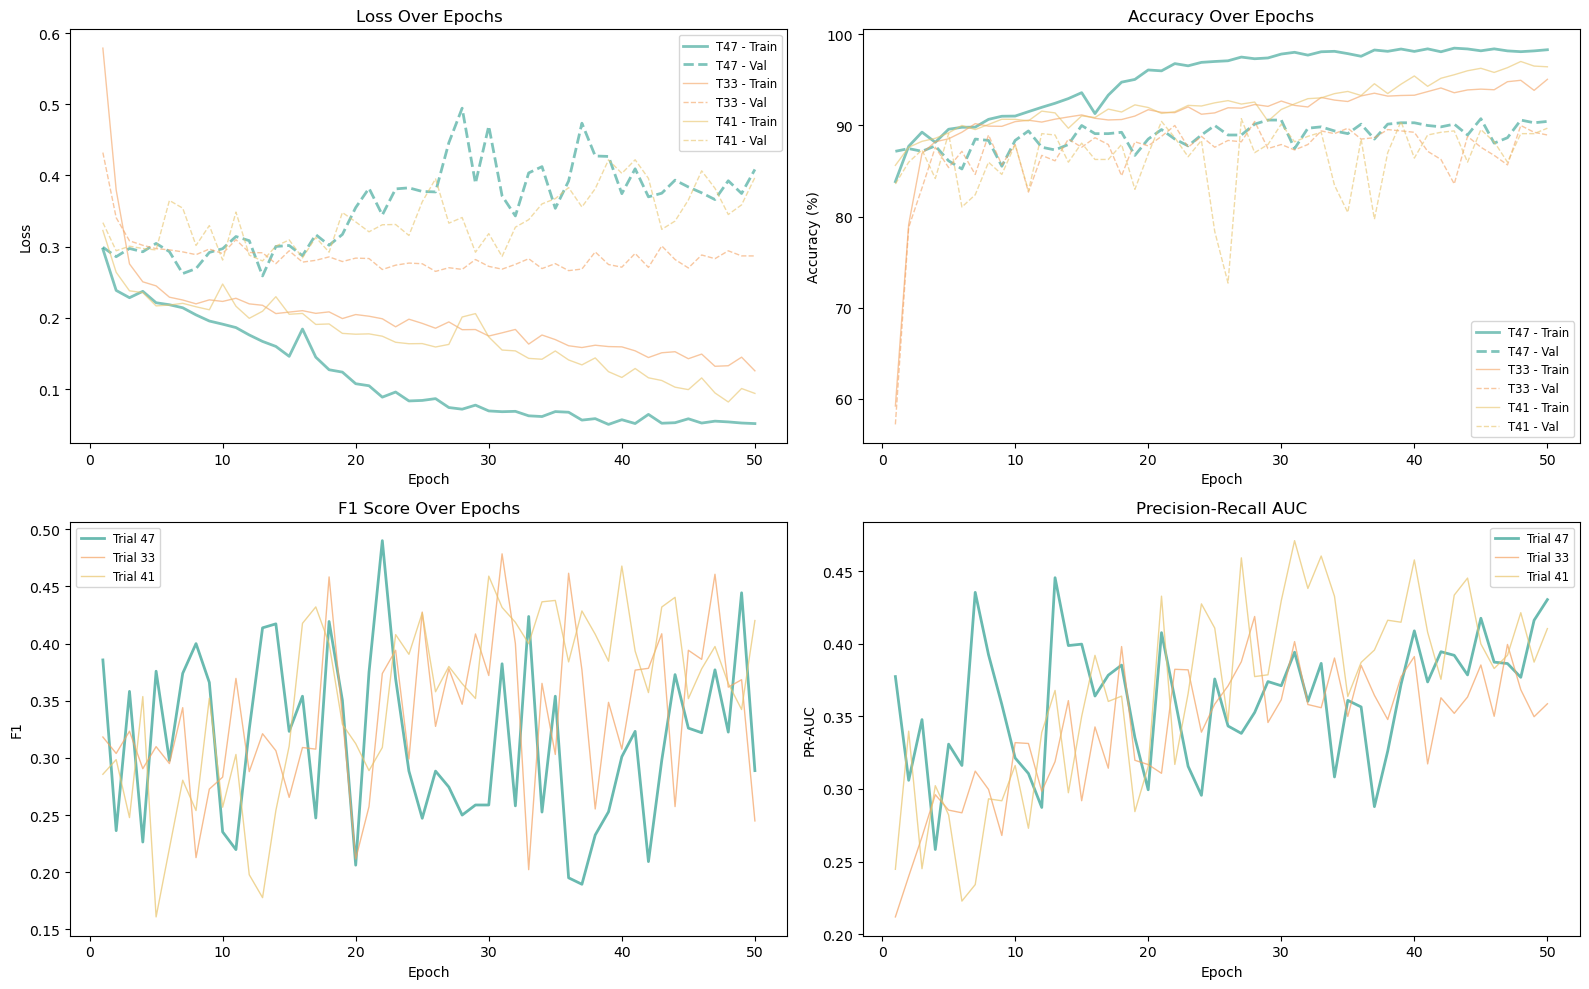

In [15]:
# === Plot figures ===
N = 3
valid_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
top_trials = sorted(valid_trials, key=lambda t: t.value, reverse=True)[:N]
best_trial = top_trials[0]

best_trial_color = '#2a9d8f' 
other_trial_colors = ['#f4a261', '#e9c46a']  

plt.figure(figsize=(16, 10))

# Plot 1: Losses
plt.subplot(2, 2, 1)
for i, trial in enumerate(top_trials):
    train_losses = trial.user_attrs.get("train_losses", [])
    val_losses = trial.user_attrs.get("val_losses", [])
    if train_losses and val_losses:
        epochs = range(1, len(train_losses) + 1)
        color = best_trial_color if trial == best_trial else other_trial_colors[i-1] 
        plt.plot(epochs, train_losses, label=f"T{trial.number} - Train", alpha=0.6, color=color, linewidth=2 if trial == best_trial else 1)
        plt.plot(epochs, val_losses, label=f"T{trial.number} - Val", linestyle="--", alpha=0.6, color=color, linewidth=2 if trial == best_trial else 1)
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize="small")

# Plot 2: Accuracy
plt.subplot(2, 2, 2)
for i, trial in enumerate(top_trials):
    train_acc = [x * 100 for x in trial.user_attrs.get("train_accuracies", [])]
    val_acc = [x * 100 for x in trial.user_attrs.get("val_accuracies", [])]
    if train_acc and val_acc:
        epochs = range(1, len(train_acc) + 1)
        color = best_trial_color if trial == best_trial else other_trial_colors[i-1]
        plt.plot(epochs, train_acc, label=f"T{trial.number} - Train", alpha=0.6, color=color, linewidth=2 if trial == best_trial else 1)
        plt.plot(epochs, val_acc, label=f"T{trial.number} - Val", linestyle="--", alpha=0.6, color=color, linewidth=2 if trial == best_trial else 1)
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(fontsize="small")

# Plot 3: F1 only
plt.subplot(2, 2, 3)
for i, trial in enumerate(top_trials):
    f1_scores = trial.user_attrs.get("f1_scores", [])
    if f1_scores:
        epochs = range(1, len(f1_scores) + 1)
        color = best_trial_color if trial == best_trial else other_trial_colors[i-1]
        plt.plot(epochs, f1_scores, label=f"Trial {trial.number}", alpha=0.7, color=color, linewidth=2 if trial == best_trial else 1)
plt.title("F1 Score Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.legend(fontsize="small")

# Plot 4: PR AUC
plt.subplot(2, 2, 4)
for i, trial in enumerate(top_trials):
    pr_auc = trial.user_attrs.get("pr_aucs", [])
    if pr_auc:
        epochs = range(1, len(pr_auc) + 1)
        color = best_trial_color if trial == best_trial else other_trial_colors[i-1]
        plt.plot(epochs, pr_auc, label=f"Trial {trial.number}", alpha=0.7, color=color, linewidth=2 if trial == best_trial else 1)
plt.title("Precision-Recall AUC")
plt.xlabel("Epoch")
plt.ylabel("PR-AUC")
plt.legend(fontsize="small")

plt.tight_layout()
plt.show()

In [ ]:
# === Functions: Visualize predictions ===
def visualize_predictions(inputs, targets, preds, max_per_group=5):
    tp, fp, fn = [], [], []

    for i in range(len(inputs)):
        input_img = inputs[i]
        true = targets[i].item()
        pred = preds[i].item()

        if true == 1 and pred == 1:
            tp.append(input_img)
        elif true == 0 and pred == 1:
            fp.append(input_img)
        elif true == 1 and pred == 0:
            fn.append(input_img)

    def plot_group(imgs, title, n=max_per_group):
        n = min(len(imgs), n)
        fig, axs = plt.subplots(1, n, figsize=(n * 2, 2))
        fig.suptitle(title)
        for i in range(n):
            img = imgs[i][0]
            axs[i].imshow(img, cmap='terrain')
            axs[i].axis('off')
        plt.tight_layout()
        plt.show()

    plot_group(tp, "True Positives")
    plot_group(fp, "False Positives")
    plot_group(fn, "False Negatives")


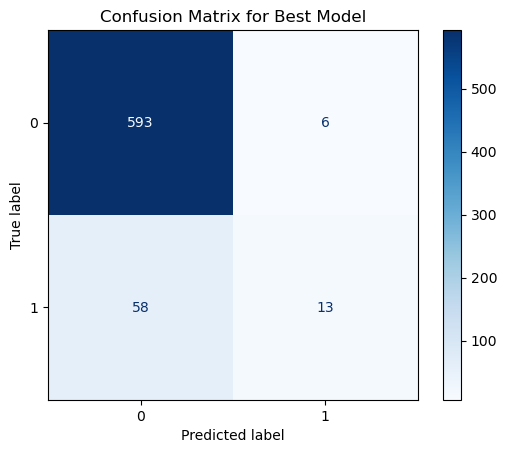

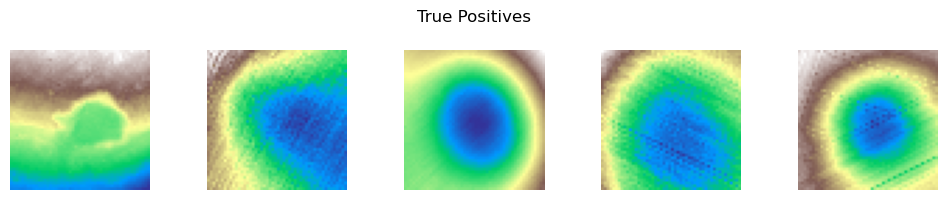

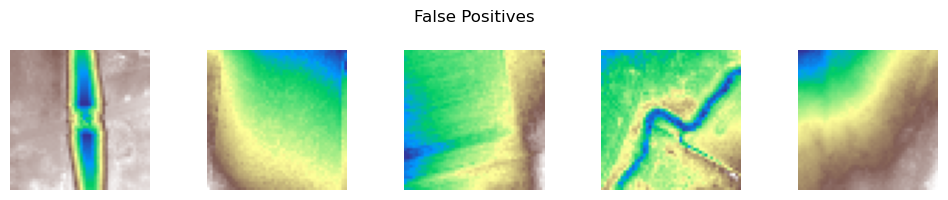

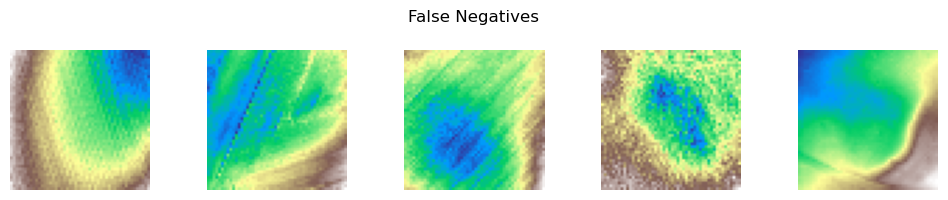

In [ ]:
# === Plot confusion matrix ===
best_trial = study.best_trial
threshold = best_trial.params["threshold"]
model_path = best_trial.user_attrs["model_path"]

model = CNN(best_trial).to(device)  # Initialize model again
model.load_state_dict(torch.load(model_path))  # Load the best model state

model.eval()
all_inputs, all_preds, all_targets, all_probs = [], [], [], []

train_loader, val_loader, _ = get_data_loaders(final_train_dataset, final_val_dataset, final_test_dataset)

with torch.no_grad():
    for data, target in val_loader: 
        data, target = data.to(device), target.to(device).float()
        output = model(data).squeeze(1)
        
        probs = torch.sigmoid(output)
        preds = (probs >= threshold).long()

        all_inputs.extend(data.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Best Model")
plt.show()

# Visualize predictions
visualize_predictions(all_inputs, all_targets, all_preds)